In [1]:
import numpy as np
import pickle

from planet_ruler.observation import LimbObservation
from planet_ruler.fit import unpack_parameters, plot_diff_evol_posteriors, package_results

# Load an Image

In [2]:
Obs = LimbObservation(image_filepath='../demo/nh-apluto-wide-9-17-15-final_0.png',
                      fit_config='../config/basic_resection.yaml')

Let's start out with this image from NASA's New Horizons mission. A couple things to note:

- You can clearly see the 'limb' of Pluto here -- the edge where the dwarf planet meets space.
- We are obviously quite high up (around 1,200 km), which makes the curvature really apparent.

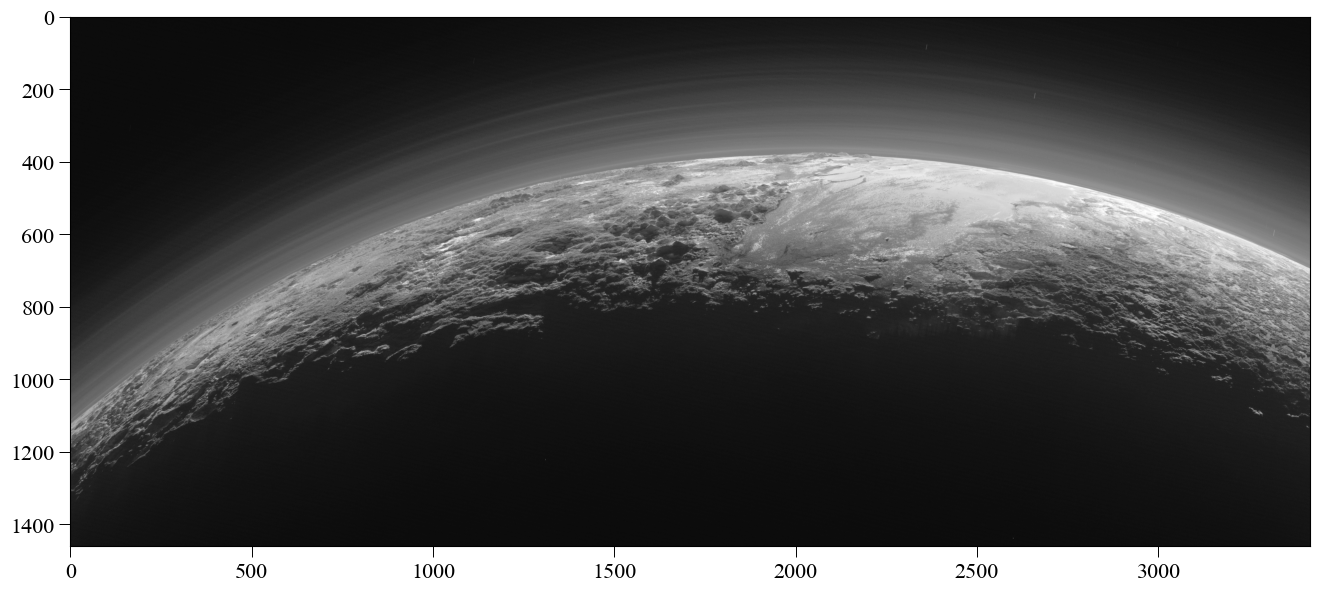

In [3]:
Obs.plot()

# Detect Limb

Next we want to define where the limb is so we can start figuring out the radius. There are many ways to go about this. For example, we could look for regions of high contrast, train some object detection ML, or simply draw by hand. Being a physics nerd I will do something a little different and fun -- we will simulate dropping a string down from the top of the image and let it 'settle' on the limb.

To make that happen we first turn the image into a topographical map by treating pixel brightness as elevation. That might look something like so:

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 10))
z = Obs.image.sum(axis=-1)
z = np.clip(z, None, 500)
nrows, ncols = z.shape
x = np.arange(ncols)
y = np.arange(nrows) 

x, y = np.meshgrid(x, y)

ls = LightSource(altdeg=30, azdeg=-15)
ax.plot_surface(x, y, z, lightsource=ls)
ax.view_init(elev=90, azim=0, roll=-90)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

plt.axis('off')
plt.show()

If we tilt this topography back somewhat and drop a string (subject to gravity and tension) onto this landscape, it will settle where the hill starts to rise -- exactly the limb we are trying to detect.

Running the next line will perform the simulation. Be warned it is not the fastest thing, but pretty robust as most physical systems are.

In [5]:
Obs.detect_limb(start=200, steps=1000000, g=150, m=5, t_step=0.01, max_vel=2, max_acc=1)

Let's take a look at the position of the string over time. It becomes less transparent as time evolves and it settles onto the limb.

In [6]:
string_positions = Obs._string_drop.string_positions
n_pos = len(string_positions)

plt.imshow(Obs.image)
steps = np.logspace(1, np.log10(n_pos - 1), num=20).astype(int)
for step in steps:
    pos = string_positions[step]
    plt.plot(np.arange(len(pos)), pos, c='yellow', alpha=(step)/(n_pos))
plt.show()

We can now smooth things out and take a look at the fitted limb location.

In [7]:
Obs.smooth_limb(method='rolling-median', window_length=50)
Obs.plot()

Let's add a save point in case we don't want to do all that again.

In [8]:
Obs.save_limb('pluto_limb.npy')

# Fit Planet Radius

Here comes the hard part. We need to deduce the radius of the object below us by leveraging what we know and fitting what we do not.

So -- what do we know?

Let's start with a list of the free parameters in the fit. These are:
- r: radius of the planet (m)
- h: height of the camera above the surface (m)
- f: focal length of the camera (m)
- pxy: the scale of pixel width/height on the projection plane (m)
<!-- - y0: the y-axis principle point (pixels -->
- theta_x: rotation around the x (horizontal) axis (radians)
- theta_z: rotation around the z (toward the horizon) axis (radians)
- origin_y: distance from the object in question to the camera (m)

In [ ]:
Obs.load_limb(limb_save)

In [5]:
Obs.load_fit_config('../config/pluto-new-horizons.yaml')
Obs.fit_limb(max_iter=10000)

differential_evolution step 1: f(x)= 141373578.540387
differential_evolution step 2: f(x)= 141373578.540387
differential_evolution step 3: f(x)= 141373578.540387
differential_evolution step 4: f(x)= 141373578.540387
differential_evolution step 5: f(x)= 141373578.540387
differential_evolution step 6: f(x)= 141373578.540387
differential_evolution step 7: f(x)= 93111226.87146473
differential_evolution step 8: f(x)= 93111226.87146473
differential_evolution step 9: f(x)= 93111226.87146473
differential_evolution step 10: f(x)= 93111226.87146473
differential_evolution step 11: f(x)= 93111226.87146473
differential_evolution step 12: f(x)= 93111226.87146473
differential_evolution step 13: f(x)= 93111226.87146473
differential_evolution step 14: f(x)= 93111226.87146473
differential_evolution step 15: f(x)= 93111226.87146473
differential_evolution step 16: f(x)= 75716213.61624578
differential_evolution step 17: f(x)= 75716213.61624578
differential_evolution step 18: f(x)= 75716213.61624578
differe

## Check Fit

By Eye

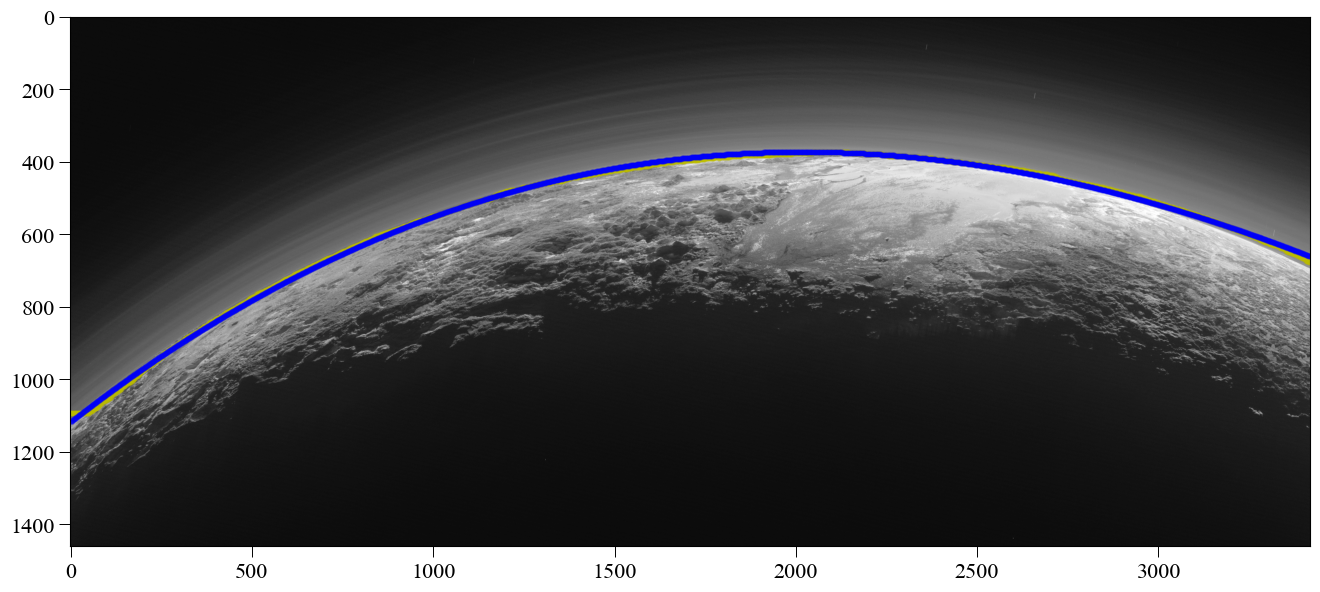

In [13]:
Obs.plot()

### Posteriors

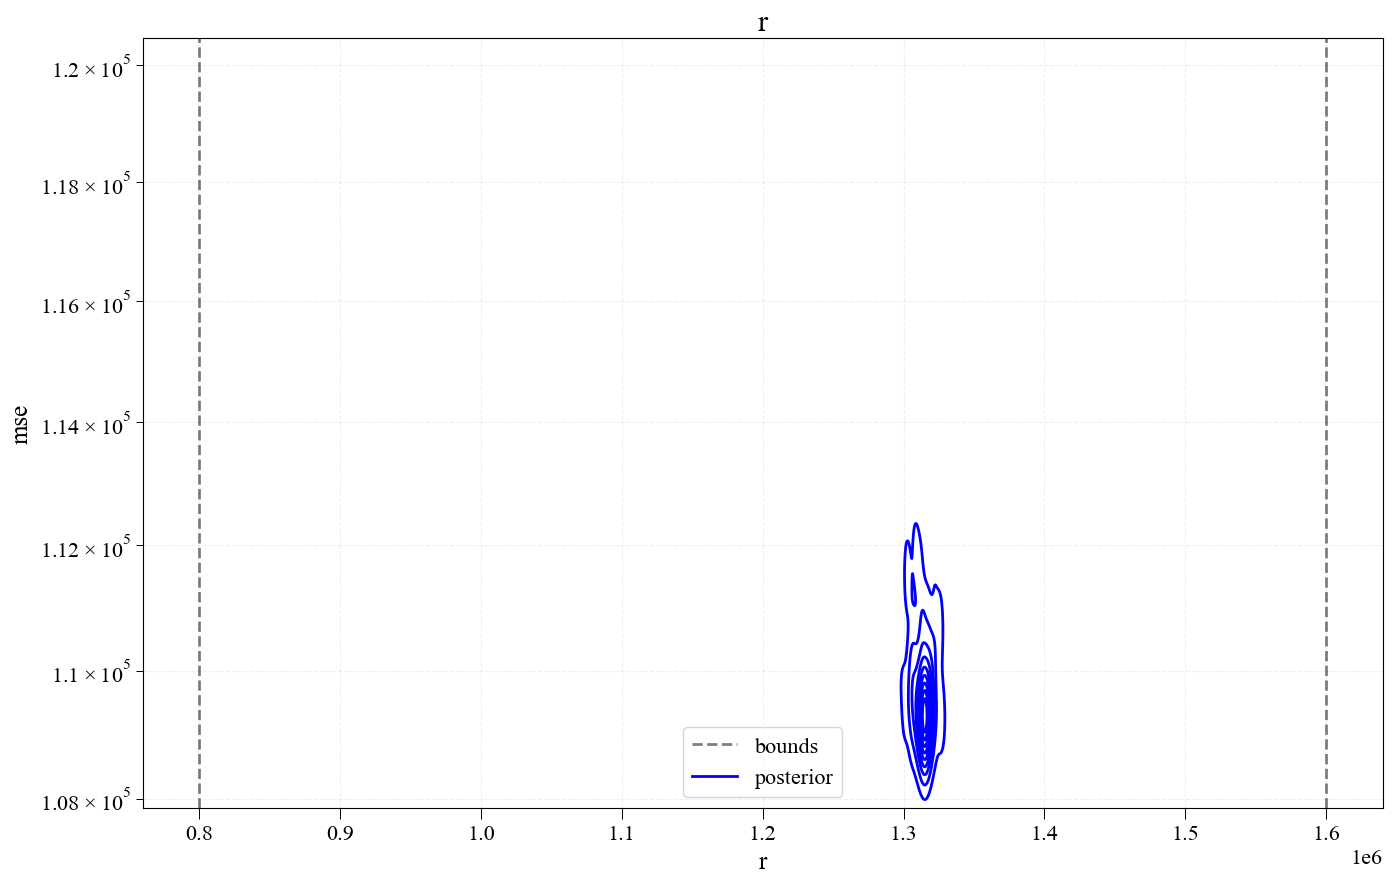

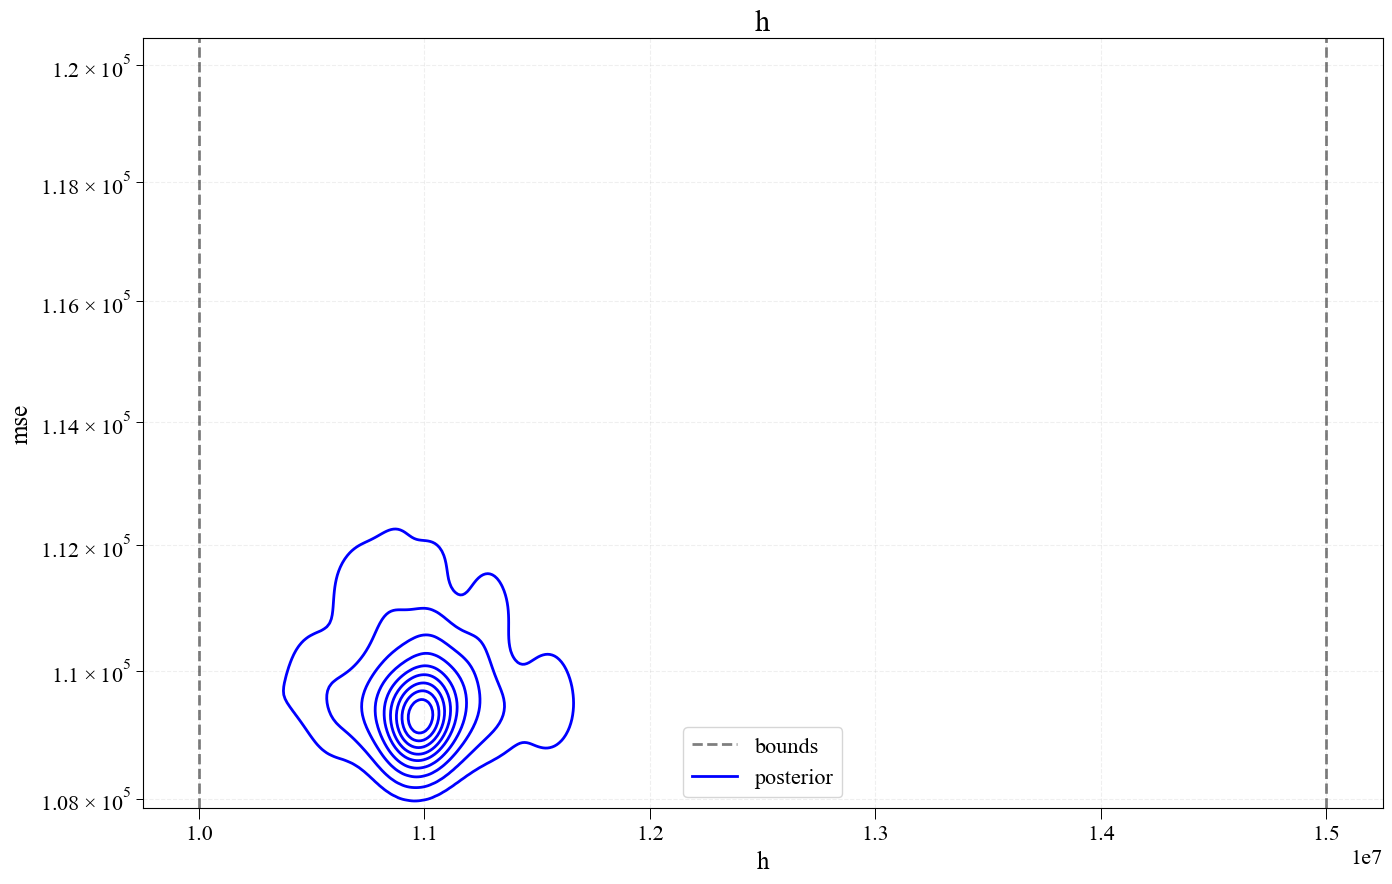

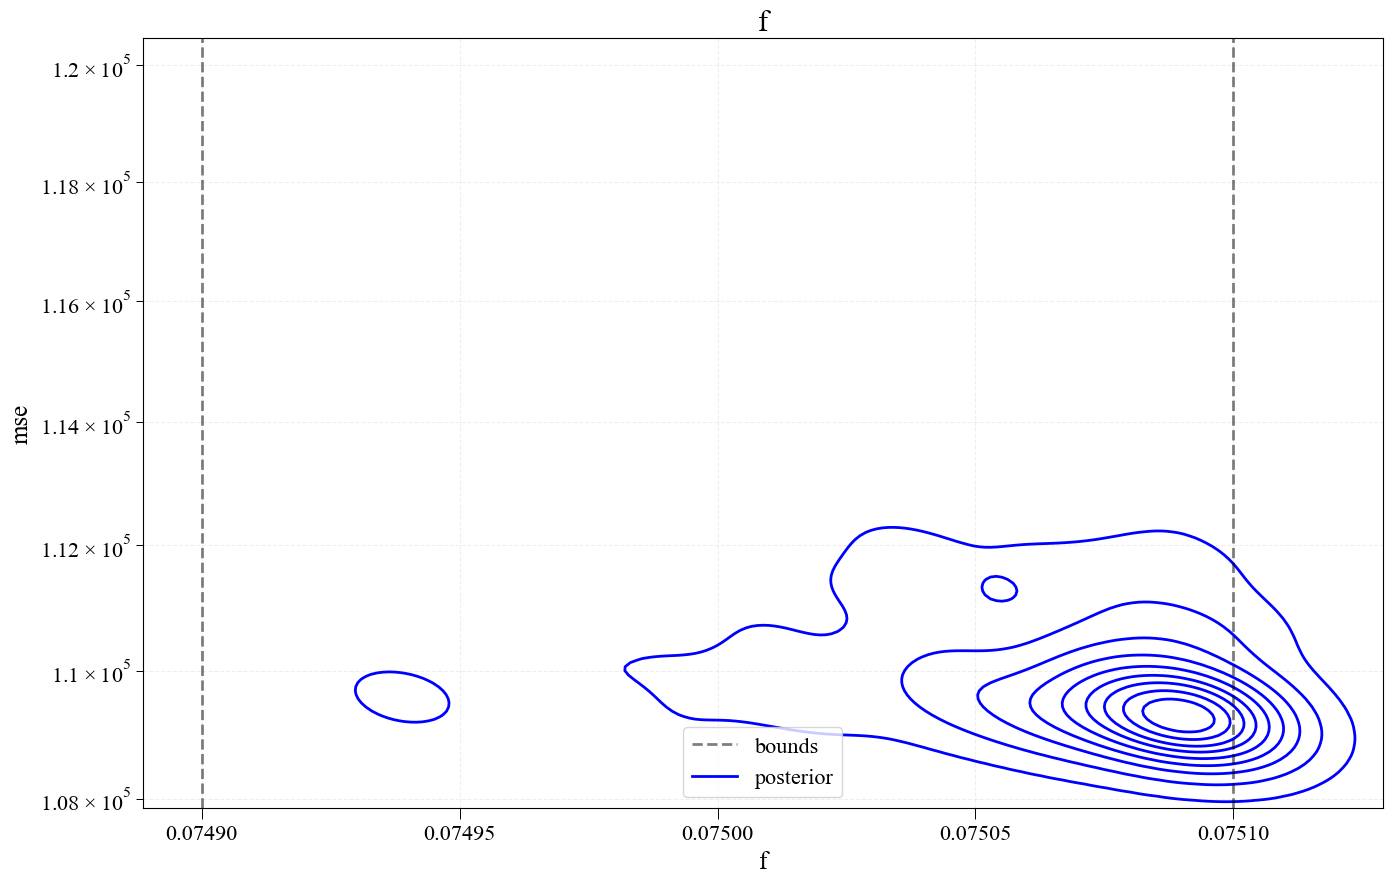

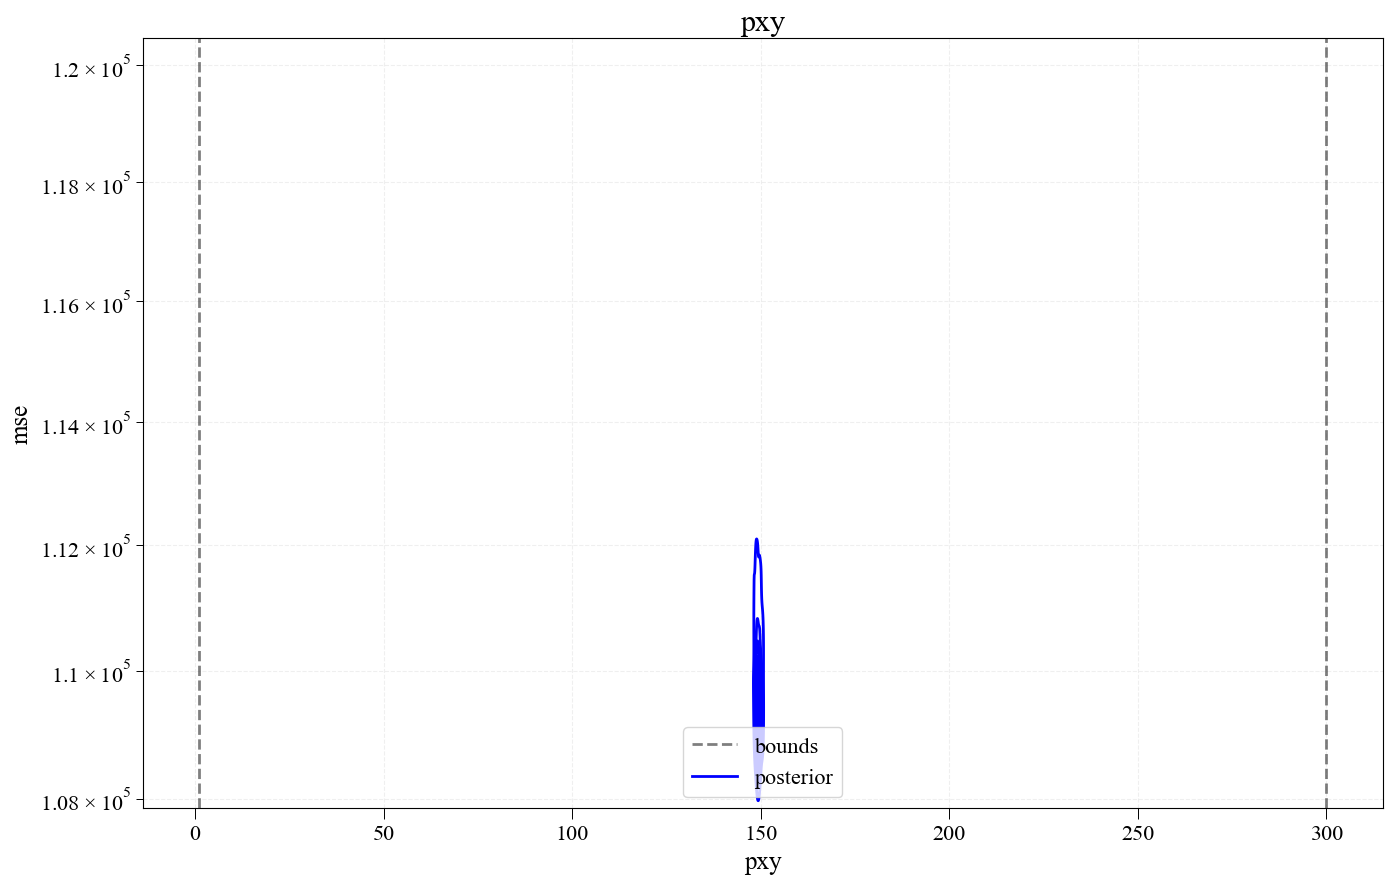

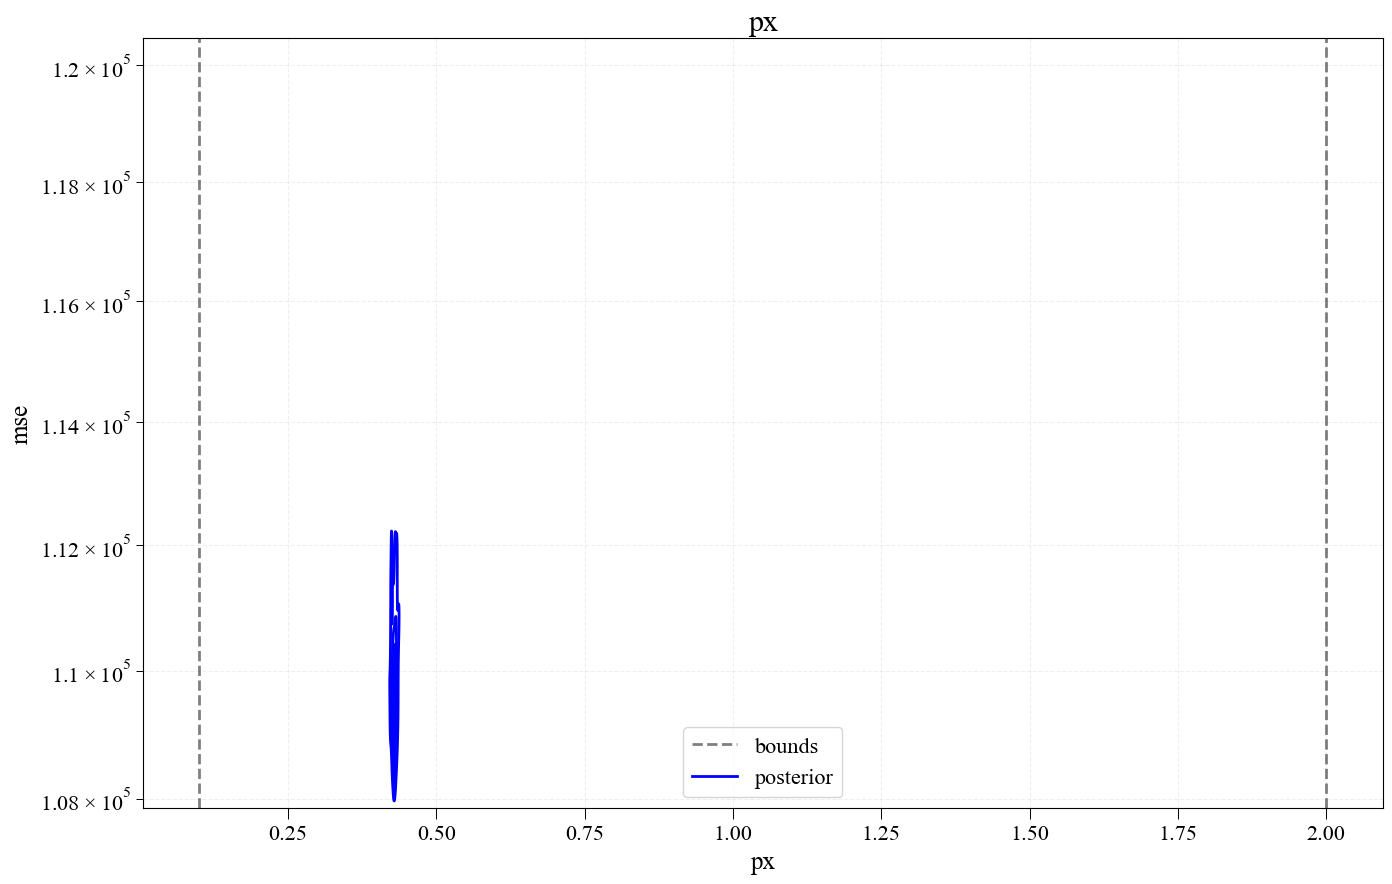

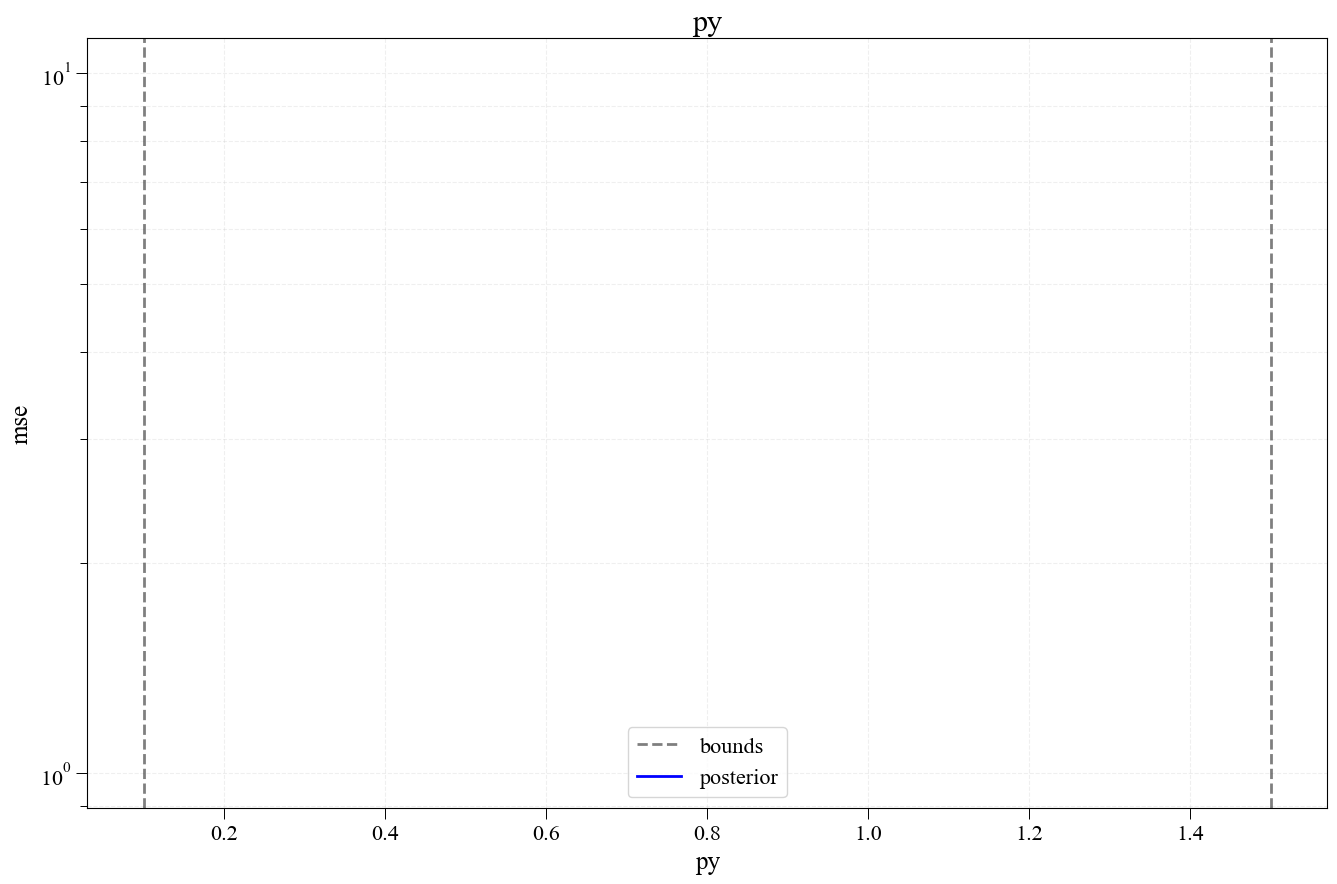

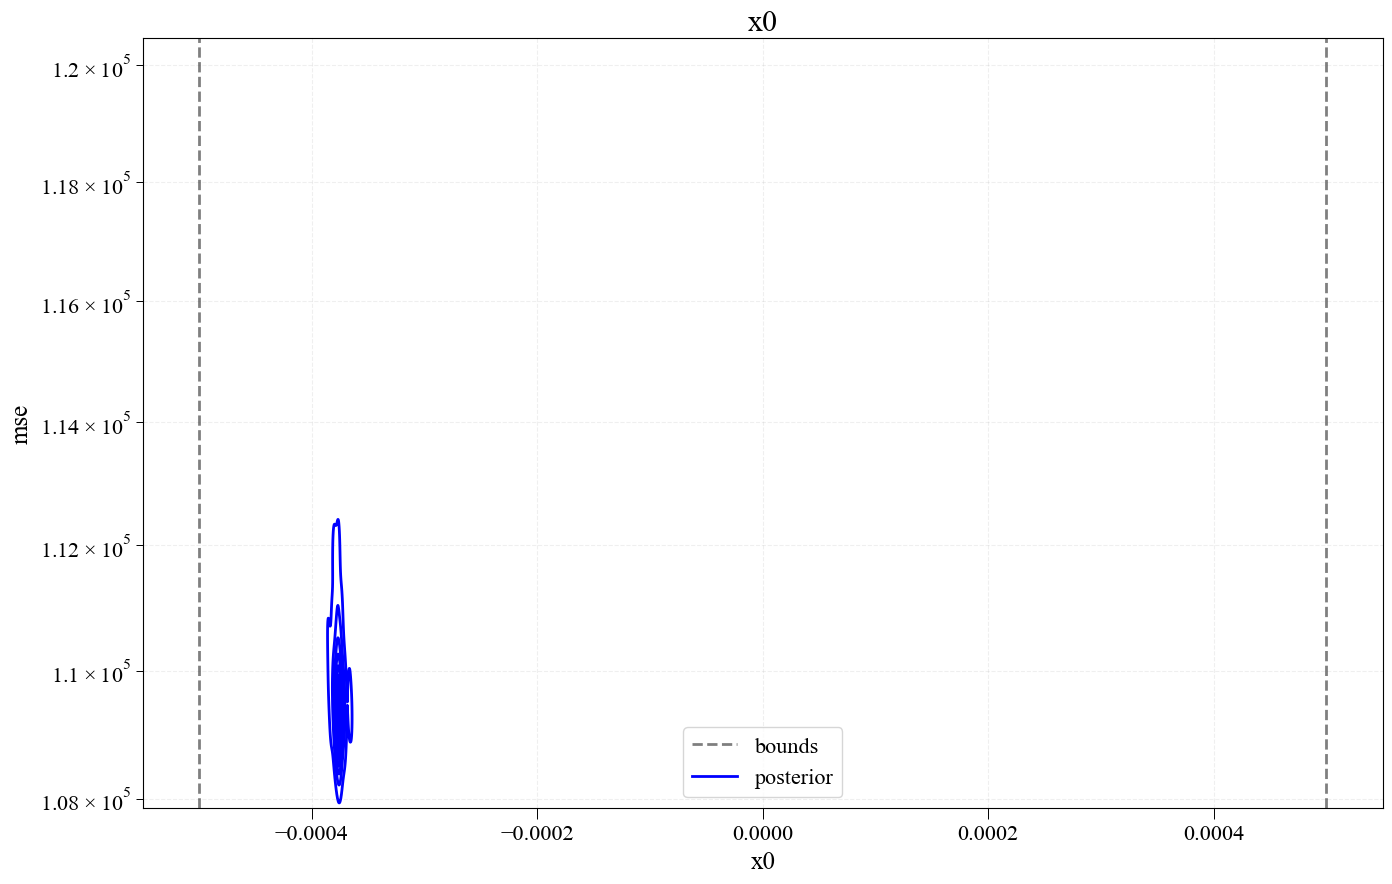

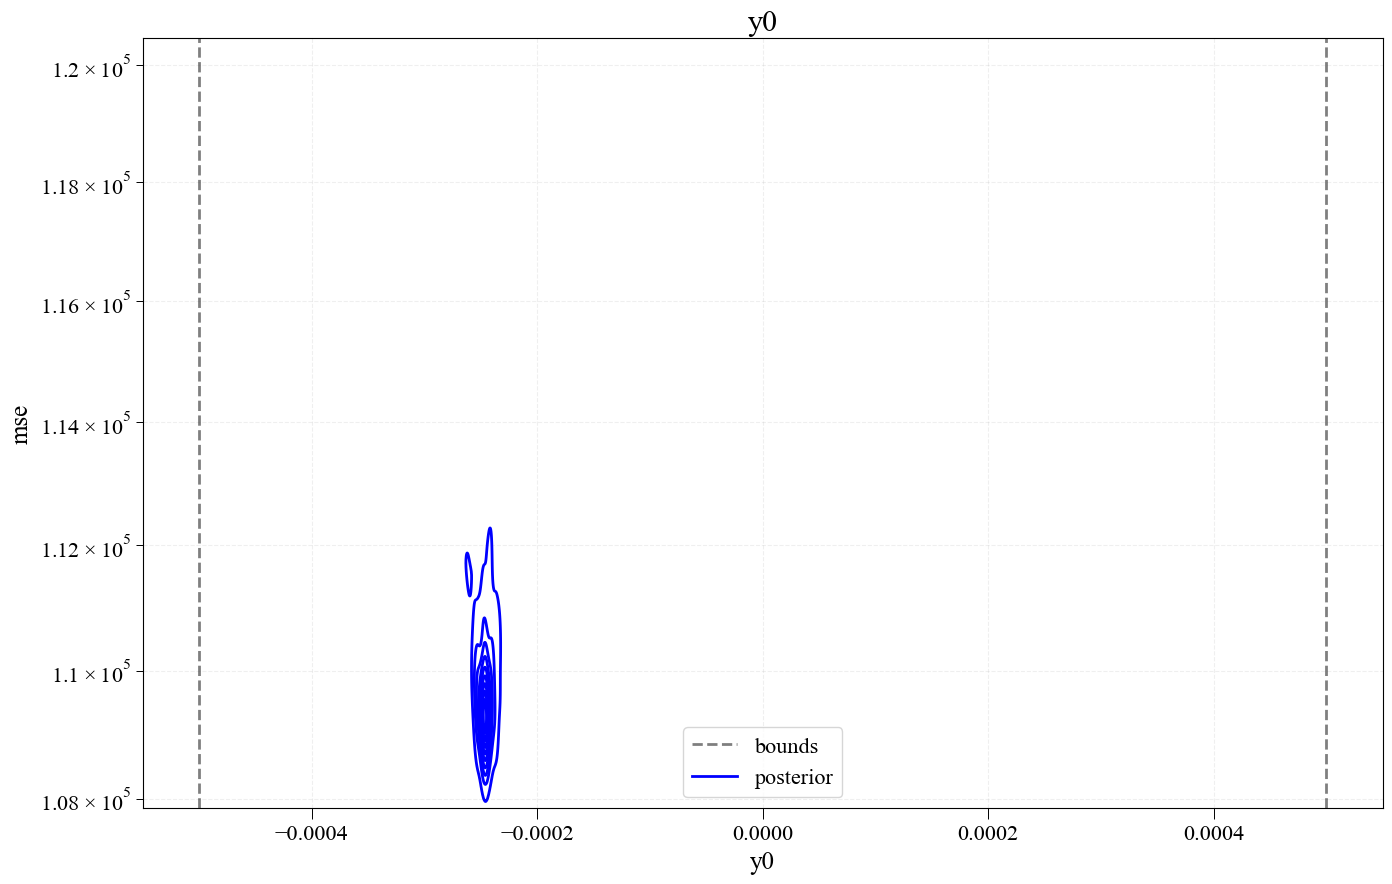

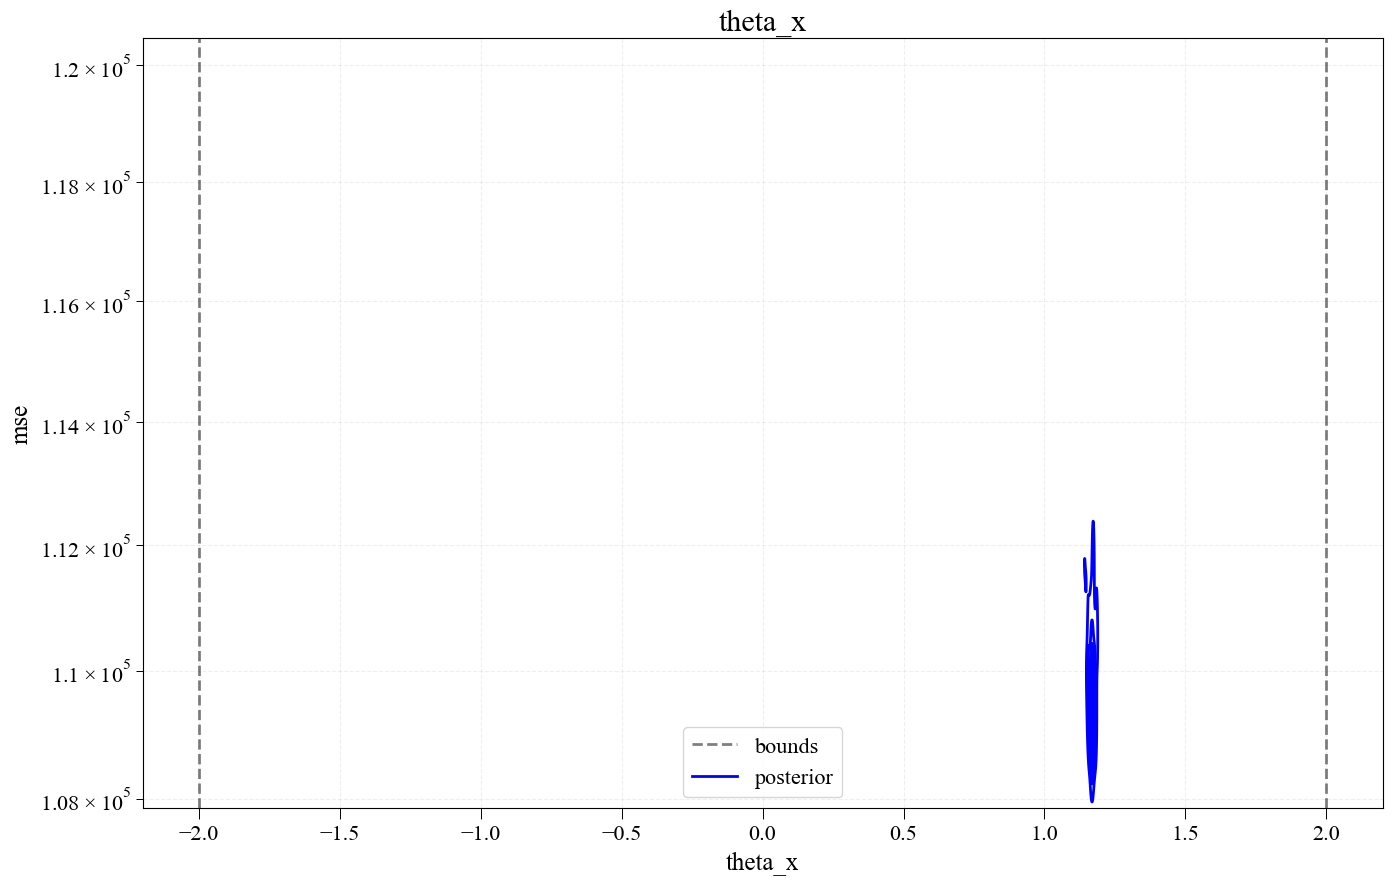

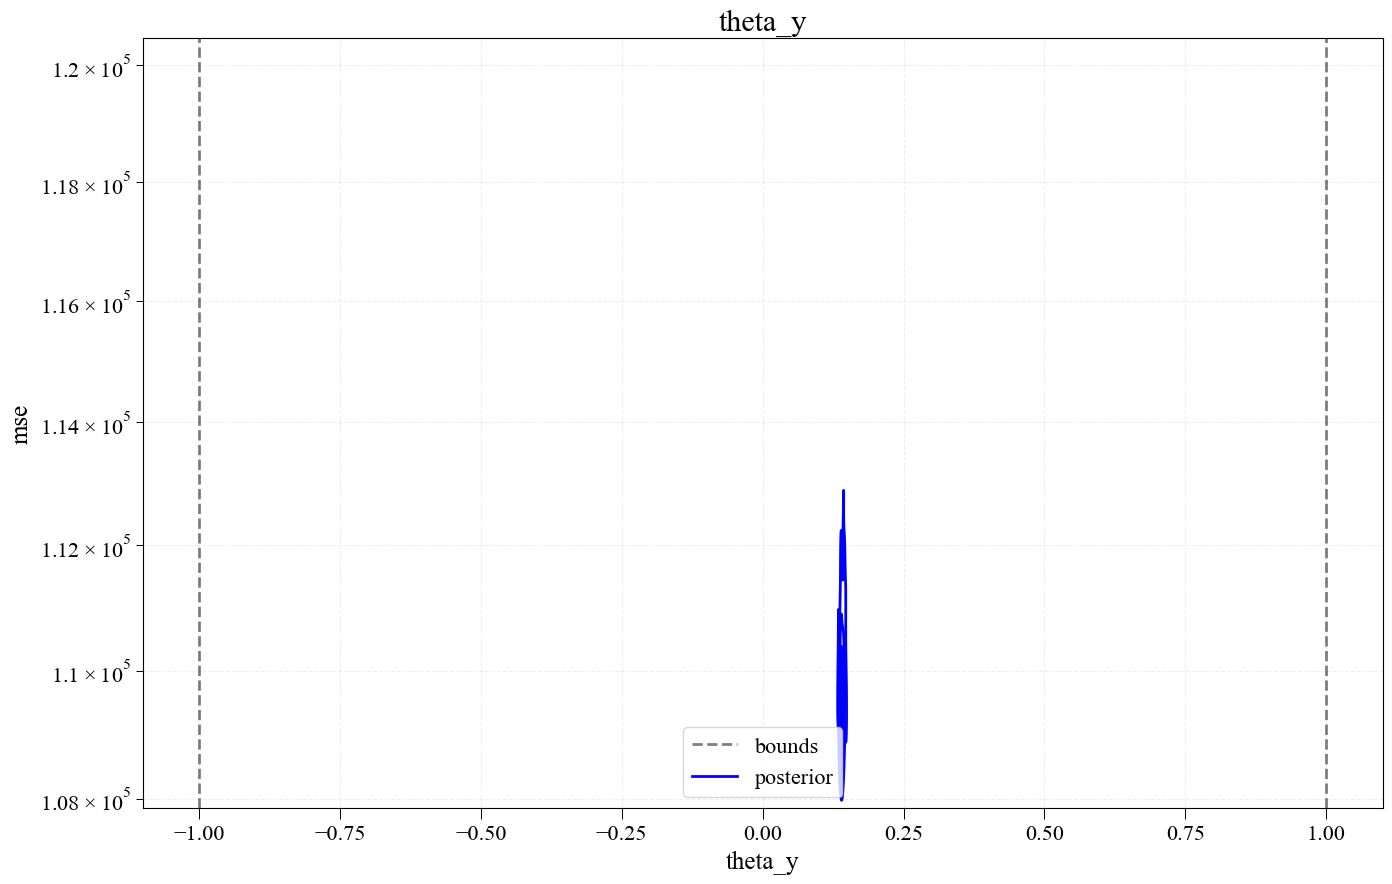

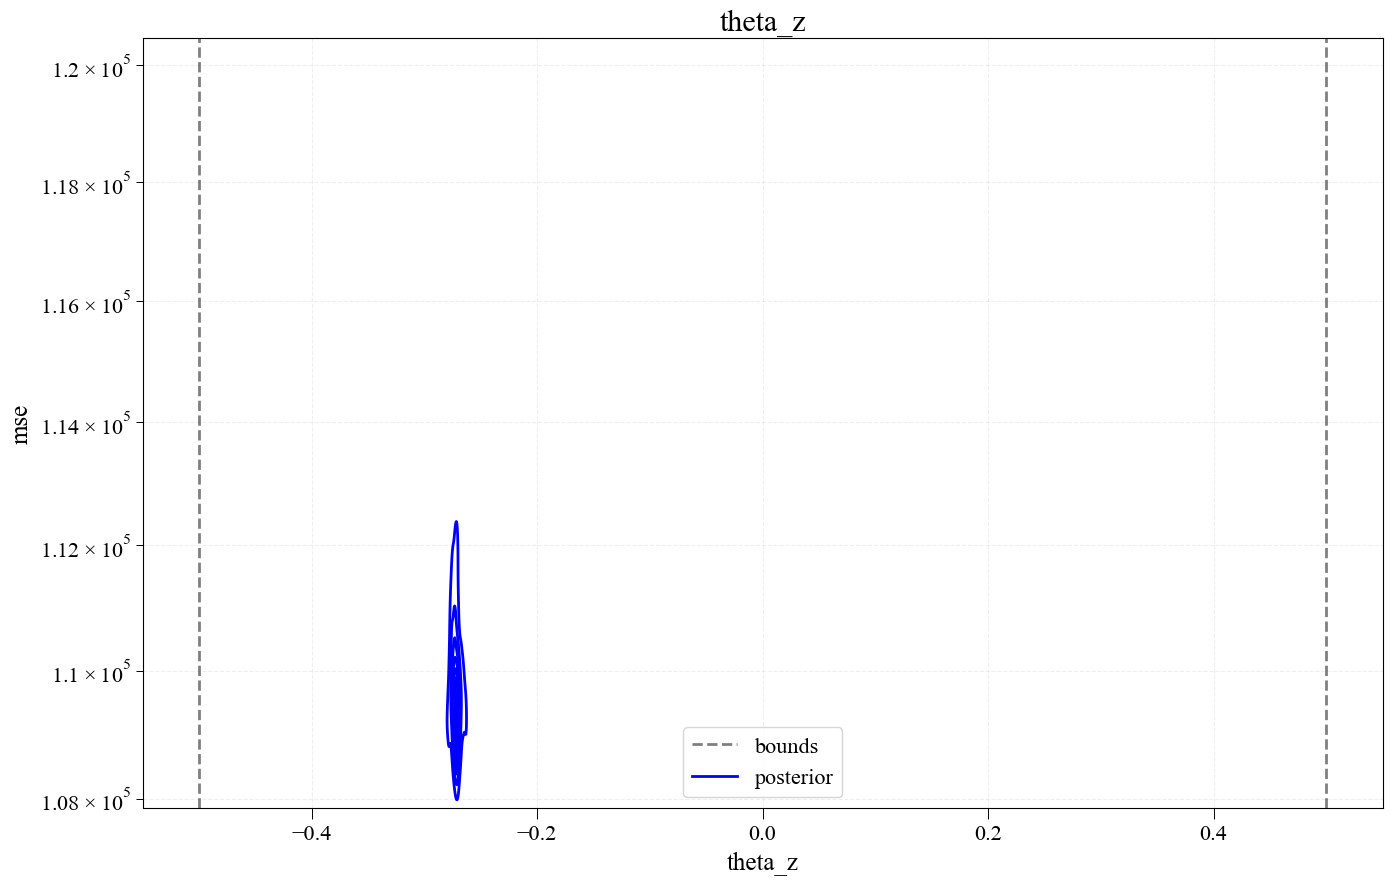

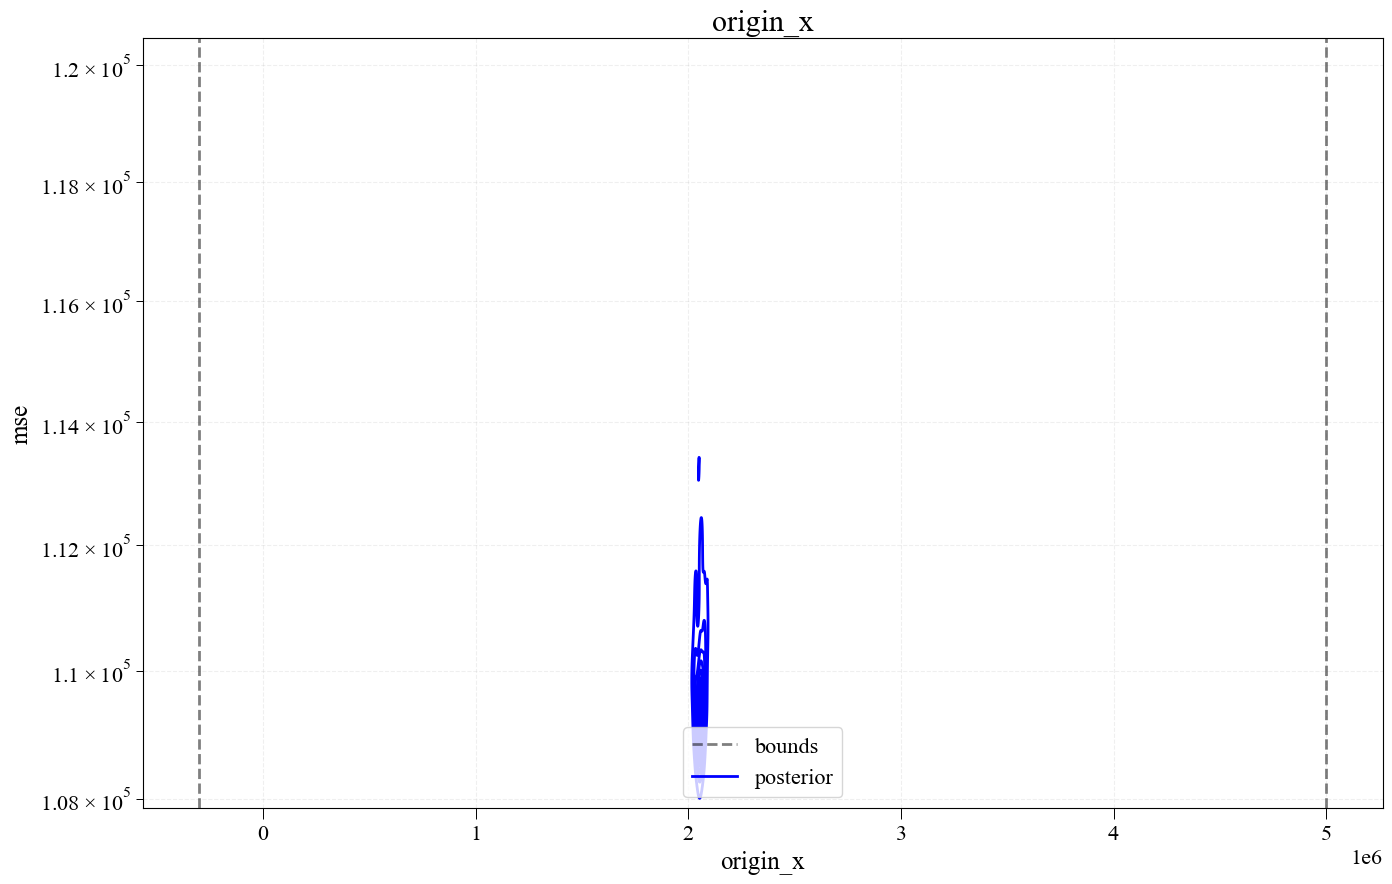

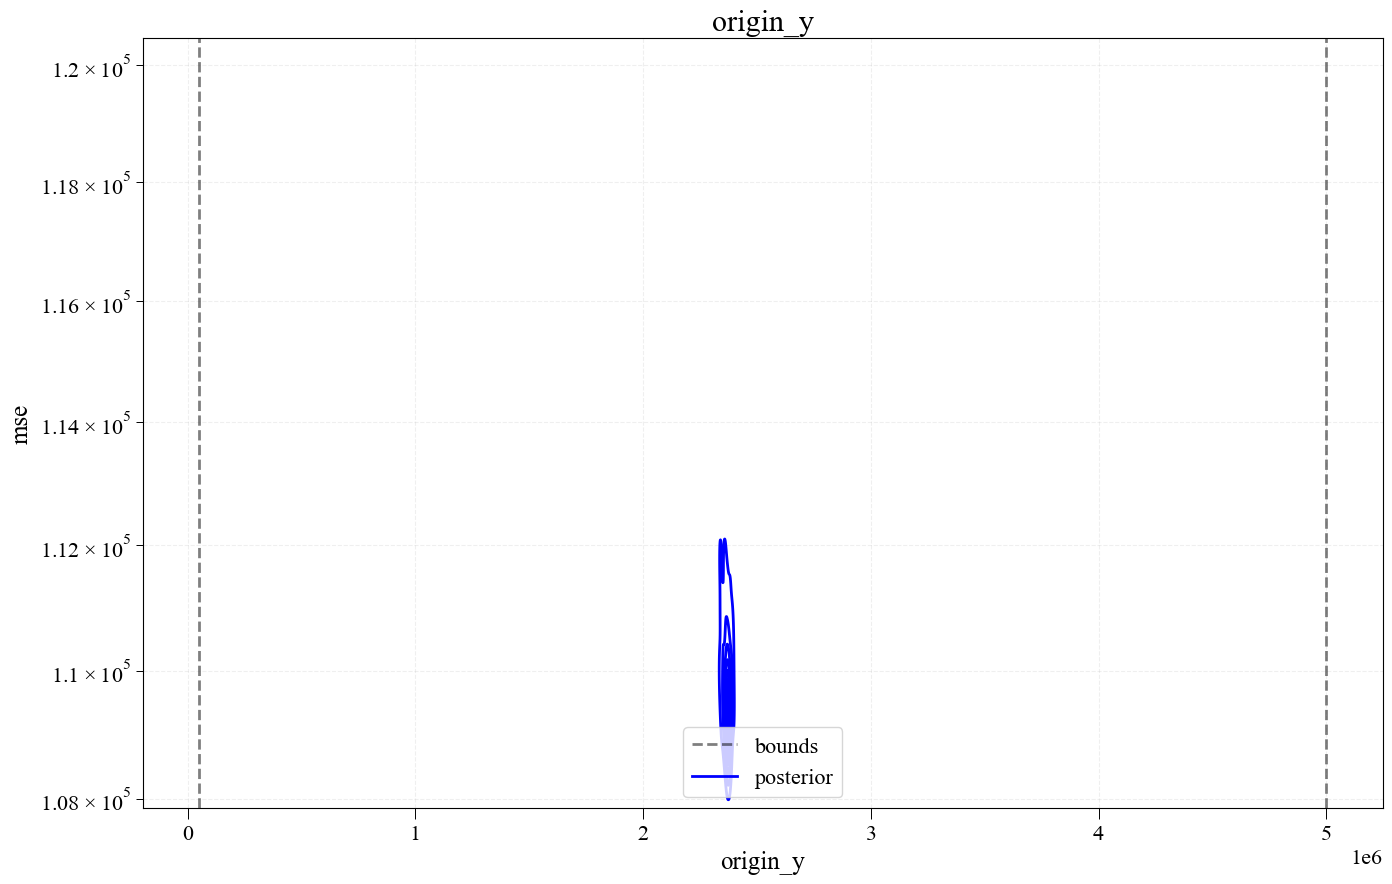

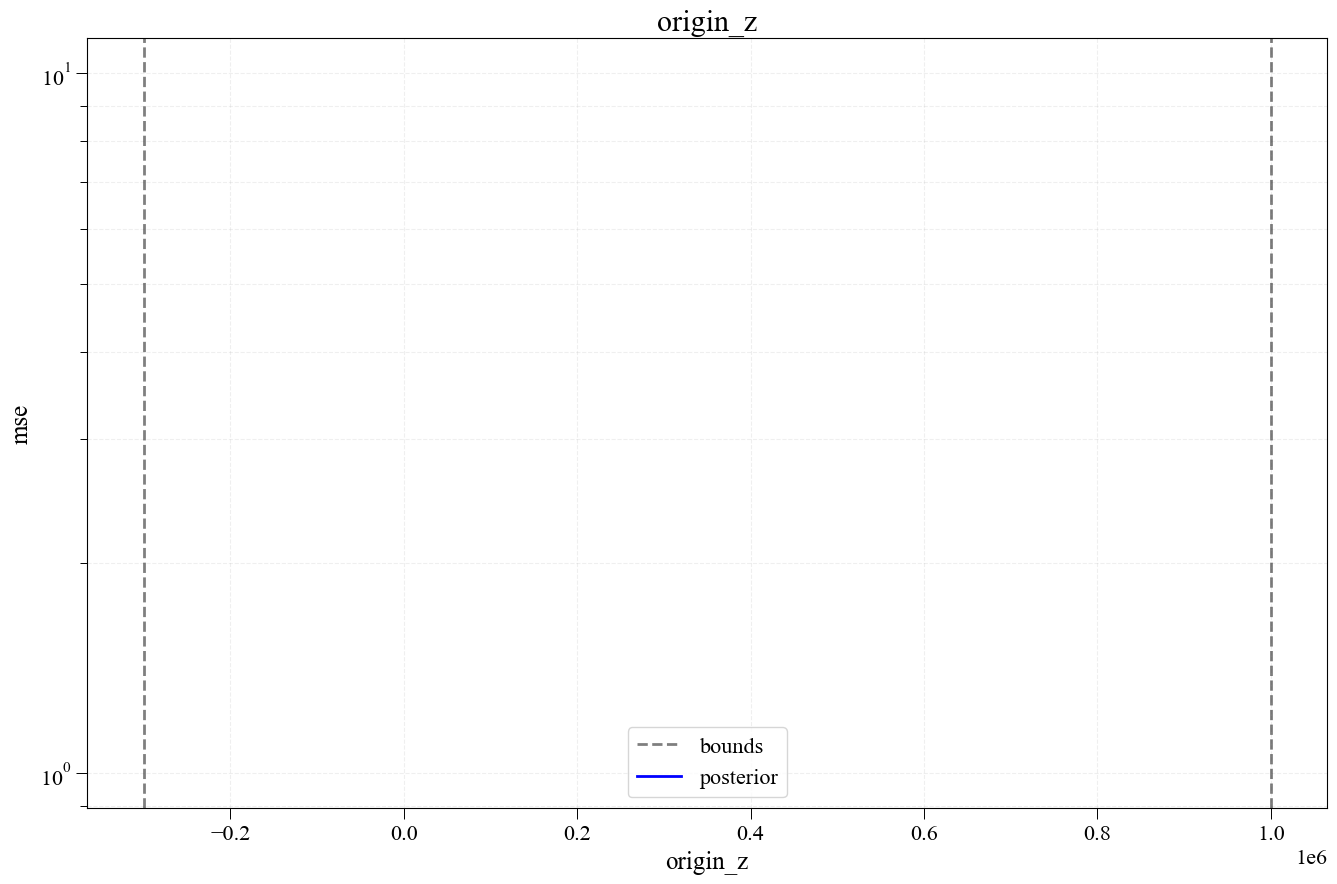

In [41]:
plot_diff_evol_posteriors(Obs)

# The Answer!

In [47]:
print(f"Our estimate of the radius is {Obs.best_parameters['r'] / 1000: .1f} kilometers.")

Our estimate of the radius is  1315.4 kilometers.


In [61]:
package_results(Obs)

,fit value,initial value
parameter,,
r,1.315406e+06,1.188300e+06
h,1.099330e+07,1.250000e+07
f,7.509293e-02,7.500000e-02
pxy,1.492804e+02,5.000000e+01
px,4.297640e-01,1.000000e+00
x0,-3.759957e-04,0.000000e+00
y0,-2.464012e-04,0.000000e+00
theta_x,1.167773e+00,1.000000e+00
theta_y,1.402638e-01,-5.000000e-01
